This notebook is used for generating plots for figure 5 in the paper "Integer Factorization through Func-QAOA"

## Setup

In [1]:
# Import necessary libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import custom modules
sys.path.append(f"./../")
from src import SpaceEfficientVQF
from src.clause_utils import keep_max_y_coordinate

## Process Data

In [2]:
m_list = [1687927, 714433477, 1753778247857, 903873756190981]

# Initialize lists to store data for all m values
all_n_vars_list = []
all_comp_ratio_list = []

# Loop over each m value and process data
for idx, m in enumerate(m_list):
    vqf = SpaceEfficientVQF(m)
    n_vars_list = []
    comp_ratio_list = []

    for c in tqdm(vqf.selected_clauses, desc=f"Processing m = {m}"):
        if c != 0:
            n_vars = len(c.pq_part.free_symbols)
            n_vars_list.append(n_vars)
            table = c.reduce_space().remove_carry_bits()
            comp_ratio = np.abs(table.calc_r())
            comp_ratio_list.append(comp_ratio)

    all_n_vars_list.append(n_vars_list)
    all_comp_ratio_list.append(comp_ratio_list)

Processing m = 903873756190981: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


## Generate Scatter Plots with Linear Fits

In [5]:
# Function to perform scatter plot and linear regression fit
def scatter_and_linear_fit(x_list, y_list):
    data = set(zip(x_list, y_list))
    filtered_data = keep_max_y_coordinate(data)
    x, y = zip(*filtered_data)
    x_fit = [xi for xi in x if xi % 2 == 0]
    y_fit = [yi for xi, yi in filtered_data if xi % 2 == 0]
    m, b = np.polyfit(x_fit, y_fit, 1)
    plt.rc("text", usetex=True)
    new_x_fit = np.asarray([np.min(x_fit), np.max(x_fit)])
    plt.plot(
        new_x_fit,
        m * np.array(new_x_fit) + b,
        "--",
        color="red",
        label=f"${round(m, 2)} x + {round(b, 2)}$",
    )
    plt.scatter(x, y)

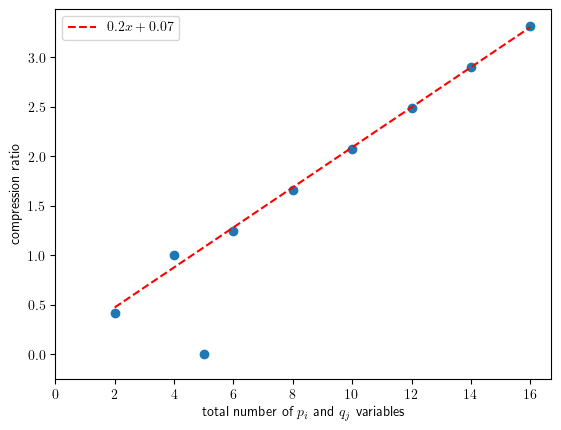

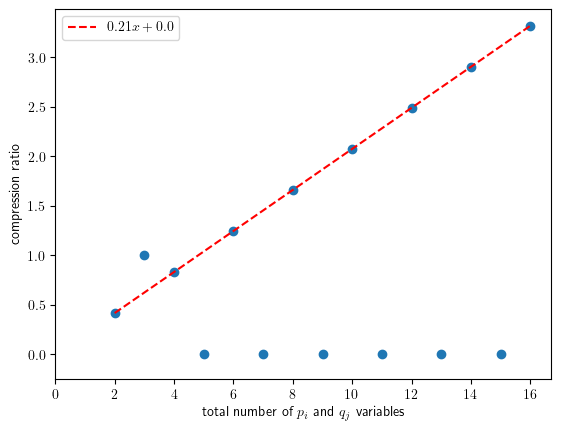

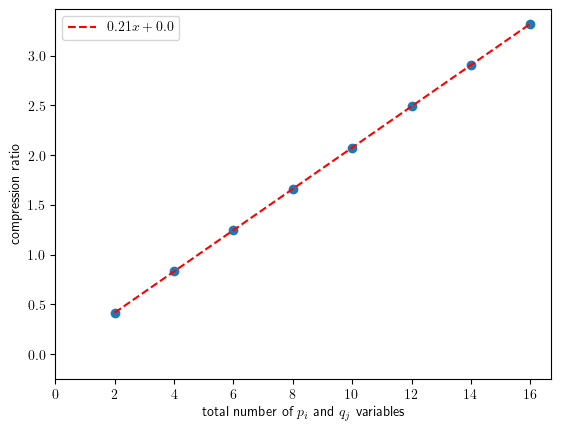

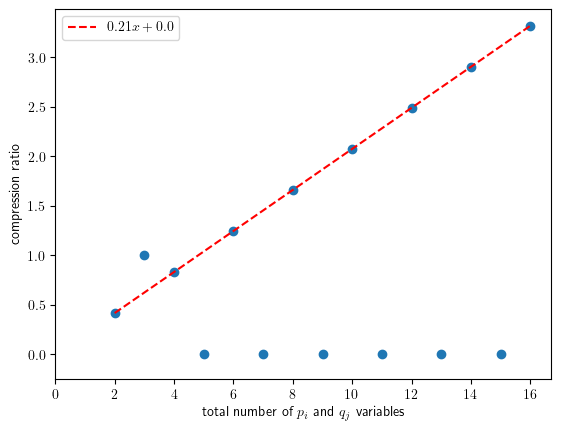

In [6]:
# Loop over m values to generate scatter plots with linear fits
for i in range(len(m_list)):
    plt.cla()
    scatter_and_linear_fit(all_n_vars_list[i], all_comp_ratio_list[i])

    plt.xlim(0, None)
    plt.ylim(-0.25, None)
    plt.xlabel("total number of $p_i$ and $q_j$ variables")
    plt.ylabel("compression ratio")
    plt.legend()

    # Save the scatter plot
    plt.savefig(f"./../data/figs/comp_ratios_{m_list[i]}.pdf")
    plt.show()